# Extract Data
Extract waveform and pulse shape data from simtelarray files using ctapipe.

In [4]:
path = "/Users/Jason/Downloads/tempdata/obs/run1.simtel.gz"

In [ ]:
from ctapipe.io.simteleventsource import SimTelEventSource

## Pulse shape

In [19]:
event_source = SimTelEventSource(input_url=path)
for event in event_source:
    telid = list(event.mc.tel.keys())[0]
    break

In [20]:
pulse_shape = event.mc.tel[telid].reference_pulse_shape[0]
step = event.mc.tel[telid].meta["refstep"]
time_slice = event.mc.tel[telid].time_slice

## Example Events

In [63]:
import numpy as np
import pandas as pd
from ctapipe.image.extractor import LocalPeakWindowSum

In [77]:
def get_charge_df(window_width, window_shift):
    event_source = SimTelEventSource(input_url=path)
    extractor = LocalPeakWindowSum(window_width=window_width, window_shift=window_shift)
    print(f"Extracting with window_width={extractor.window_width} and window_shift={extractor.window_shift}")
    df_list = []
    for event in event_source:
        true_charge = event.mc.tel[telid].photo_electron_image
        waveform = event.r1.tel[telid].waveform
        extracted_charge = extractor(waveform)[0]
        df_list.append(pd.DataFrame({
            'iev': event.count,
            'ipix': np.arange(true_charge.size),
            'true': true_charge,
            'extracted': extracted_charge,
        }))
    df = pd.concat(df_list)
    df = df.loc[df['true'] < 1000] # Ignore saturation for this investigation
    return df

In [103]:
# Create datasets
windows = [[20, 10], [12, 5], [12, 1], [8, 5], [8, 3], [4, 3]]
dfs = dict()
for window in windows:
    dfs[f'w_{window[0]}_{window[1]}'] = get_charge_df(*window)

Extracting with window_width=[('type', '*', 20)] and window_shift=[('type', '*', 10)]
Extracting with window_width=[('type', '*', 12)] and window_shift=[('type', '*', 5)]
Extracting with window_width=[('type', '*', 12)] and window_shift=[('type', '*', 1)]
Extracting with window_width=[('type', '*', 8)] and window_shift=[('type', '*', 5)]
Extracting with window_width=[('type', '*', 8)] and window_shift=[('type', '*', 3)]
Extracting with window_width=[('type', '*', 4)] and window_shift=[('type', '*', 3)]


w_20_10
w_12_5
w_12_1
w_8_5
w_8_3
w_4_3


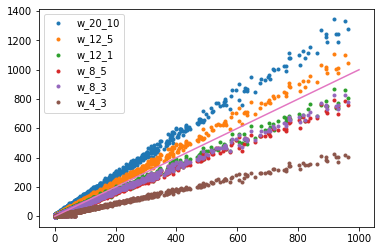

In [95]:
# Check charge distribution
from matplotlib import pyplot as plt
%matplotlib inline

for key, df in dfs.items():
    plt.plot(df['true'], df['extracted'], '.', label=key)
plt.legend(loc='best')
plt.plot([0, 1000], [0, 1000])

## Save data to HDF5

In [105]:
with pd.HDFStore("data.h5") as store:
    for key, df in dfs.items():
        store[key] = df

    metadata = {
        'pulse_shape': pulse_shape,
        'step': step,
        'time_slice': time_slice,
    }
    store['meta'] = pd.DataFrame()
    for key, value in metadata.items():
       store.get_storer("meta").attrs[key] = value